## Preprocess data to get training and testing data

I,II,III,aVL,aVR,aVF,V1–V6

In [1]:
# Import package
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal
# from biosppy.signals import ecg
import neurokit2 as nk
from sklearn import *
from collections import OrderedDict

In [2]:
#Set the read file path
path = '/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/'

X = np.load(path + 'raw100.npy', allow_pickle=True)
sampling_rate = 100

In [3]:
# Read the file and convert tags
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
X.shape

(21801, 1000, 12)

In [5]:
# Get diagnostic information in scp_statements.csv
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [6]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [7]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in agg_df.index:
            res.add(agg_df.loc[k].diagnostic_class)
    return list(res)

In [8]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [9]:
Y['scp_classes'] = Y.scp_codes.apply(diagnostic_class)

In [10]:
Z = pd.DataFrame(0, index=Y.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in Y.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


In [11]:
hyp_cases = Z[Z['HYP'] == 1]
hyp_cases.head(20)

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
30,0,0,0,0,1
45,0,0,0,1,1
96,0,0,0,0,1
106,0,1,0,0,1
138,0,0,0,0,1
146,0,1,1,0,1
162,0,1,1,1,1
173,0,0,1,0,1
191,0,0,0,1,1


In [12]:
#Add diagnostic information
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [13]:
Y.diagnostic_superclass.value_counts()

diagnostic_superclass
[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[MI, CD]               1300
[STTC, HYP]             781
[MI, STTC]              600
[HYP]                   535
[STTC, CD]              471
[NORM, CD]              407
[]                      405
[MI, STTC, HYP]         361
[CD, HYP]               300
[MI, STTC, CD]          223
[STTC, CD, HYP]         211
[MI, HYP]               183
[MI, STTC, CD, HYP]     156
[MI, CD, HYP]           117
[NORM, STTC]             28
[NORM, STTC, CD]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, MI, CD, HYP]       1
Name: count, dtype: int64

In [14]:

X_all = X[(Y.strat_fold <= 11)]
X_all.shape

(21801, 1000, 12)

In [ ]:
save_path = '/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/data/'

np.save(save_path+'x_all.npy', X_all)

In [14]:
# Split data into train and test
test_fold = 10
# # Train
X_train = X[(Y.strat_fold <= 8)]
# y_train = Z[Y.strat_fold <= 8]
y_train = Y[(Y.strat_fold <= 8)].diagnostic_superclass
# # Test
X_test = X[(Y.strat_fold >8)]
# y_test = Z[Y.strat_fold > 8]
y_test = Y[(Y.strat_fold > 8)].diagnostic_superclass


print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(17420, 1000, 12) (17420,)
(4381, 1000, 12) (4381,)


In [15]:
# Display y_train for rows 100 to 150
print(y_train.iloc[2000:3000])


ecg_id
2691             [STTC]
2695             [NORM]
2696    [STTC, MI, HYP]
2699             [NORM]
2700             [NORM]
             ...       
4035             [NORM]
4036             [NORM]
4037             [NORM]
4038           [CD, MI]
4039             [NORM]
Name: diagnostic_superclass, Length: 1000, dtype: object


In [16]:
save_path = '/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/data/'

np.save(save_path+'x_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'x_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))

## ECG SHaP starts

In [2]:
from tensorflow.keras import layers, optimizers, losses, metrics, activations, regularizers, callbacks
from keras.models import Model
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM

In [3]:
path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/data/"
x_train = np.load(path + 'x_train.npy')
y_train = np.load(path + 'y_train.npy', allow_pickle=True)
x_test  = np.load(path + 'x_test.npy')
y_test  = np.load(path + 'y_test.npy', allow_pickle=True)
print(x_train.shape)

(17420, 1000, 12)


In [4]:
x_train = x_train.transpose(0, 2, 1)            # transpose working correctly
x_test  = x_test.transpose(0, 2, 1)
print(x_train.shape)

(17420, 12, 1000)


In [5]:
x_train = x_train.reshape(17420, 12, 1000, 1)   # Add another channel
x_test  = x_test.reshape(4381, 12, 1000, 1)

In [6]:
print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)
print('Data loaded')

# Old OUTPUTS:
# (19601, 1000, 12)
# (19601, 12, 1000)
# x_train : (19601, 12, 1000, 1)
# y_train : (19601,)
# x_test  : (2198, 12, 1000, 1)
# y_test  : (2198,)
# Data loaded

x_train : (17420, 12, 1000, 1)
y_train : (17420,)
x_test  : (4381, 12, 1000, 1)
y_test  : (4381,)
Data loaded


In [6]:
x_test.shape

(4381, 12, 1000, 1)

In [7]:

from sklearn.preprocessing import MultiLabelBinarizer
# Convert multi-label target labels to one-hot encoded matrix
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
print("Classes:", mlb.classes_)

Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [8]:
value_at_index = y_train[6666]
print(value_at_index)

[0 0 0 1 0]


In [9]:
y_train.shape

(17420, 5)

In [10]:
y_test.shape

(4381, 5)

In [14]:
#Enhanced ST-CNN
# # Main Version
# input = layers.Input(shape=(12, 1000, 1))

# X = layers.Conv2D(filters=32, kernel_size=(1, 5))(input)
# X = layers.BatchNormalization()(X)
# X = layers.ReLU()(X)
# X = layers.MaxPooling2D(pool_size=(1, 2), strides=1)(X)

# convC1 = layers.Conv2D(filters=64, kernel_size=(1, 7))(X)

# X = layers.Conv2D(filters=32, kernel_size=(1, 5))(X)
# X = layers.BatchNormalization()(X)
# X = layers.ReLU()(X)
# X = layers.MaxPooling2D(pool_size=(1, 4), strides=1)(X)

# convC2 = layers.Conv2D(filters=64, kernel_size=(1, 6))(convC1)

# X = layers.Conv2D(filters=64, kernel_size=(1, 5))(X)
# X = layers.BatchNormalization()(X)
# X = layers.Add()([convC2, X])           # skip Connection
# X = layers.ReLU()(X)
# X = layers.MaxPooling2D(pool_size=(1, 2), strides=1)(X)

# convE1 = layers.Conv2D(filters=32, kernel_size=(1, 4))(X)

# X = layers.Conv2D(filters=64, kernel_size=(1, 3))(X)
# X = layers.BatchNormalization()(X)
# X = layers.ReLU()(X)
# X = layers.MaxPooling2D(pool_size=(1, 4), strides=1)(X)

# convE2 = layers.Conv2D(filters=64, kernel_size=(1, 5))(convE1)

# X = layers.Conv2D(filters=64, kernel_size=(1, 3))(X)
# X = layers.BatchNormalization()(X)
# X = layers.Add()([convE2, X])         # skip Connection
# X = layers.ReLU()(X)
# X = layers.MaxPooling2D(pool_size=(1, 2), strides=1)(X)
# print('Added 5 layers for temporal analysis')

# X = layers.Conv2D(filters=64, kernel_size=(12, 1))(X)
# X = layers.BatchNormalization()(X)
# X = layers.ReLU()(X)
# X = layers.GlobalAveragePooling2D()(X)
# print('Added 1 layer for spatial Analysis')

# X = layers.Flatten()(X)
# print(X.shape)

# X = layers.Dense(units=128, kernel_regularizer=regularizers.L2(0.005))(X)
# X = layers.BatchNormalization()(X)
# X = layers.ReLU()(X)
# X = layers.Dropout(rate=0.1)(X)

# X = layers.Dense(units=64, kernel_regularizer=regularizers.L2(0.009))(X)
# X = layers.BatchNormalization()(X)
# X = layers.ReLU()(X)
# X = layers.Dropout(rate=0.15)(X)
# print('Added 2 fully connected layers')

# output = layers.Dense(5, activation='sigmoid')(X)
# model = Model(inputs=input, outputs=output)
# print(model.summary())

Added 5 layers for temporal analysis
Added 1 layer for spatial Analysis
(None, 64)
Added 2 fully connected layers
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 1000, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 12, 996, 32)          192       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 12, 996, 32)          128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                             

Hyper parameter tuning:
EarlyStopping monitors a specified metric, here: "val_loss"
If the val_loss does not improve for a certain number of epochs defined by patience (in this case, 6 epochs), training is stopped early.
The restore_best_weights=True argument ensures that the weights of the model are restored to the best weights when training stopped.

Learning Rate Reduction:
ReduceLROnPlateau monitors the validation loss ("val_loss").
If the validation loss does not improve for a certain number of epochs defined by patience (in this case, 3 epochs), the learning rate is reduced by a factor defined by factor.

In [12]:
#Enhanced ST-CNN
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

# Main Version
input = layers.Input(shape=(12, 1000, 1))

X = layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same')(input)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 2), strides=1, padding='same')(X)

convC1 = layers.Conv2D(filters=64, kernel_size=(1, 7), padding='same')(X)

X = layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same')(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 4), strides=1, padding='same')(X)

convC2 = layers.Conv2D(filters=64, kernel_size=(1, 6), padding='same')(convC1)

X = layers.Conv2D(filters=64, kernel_size=(1, 5), padding='same')(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
residual_1 = layers.Add()([convC2, X])           # skip Connection
X = layers.ReLU()(residual_1)
X = layers.MaxPooling2D(pool_size=(1, 2), strides=1, padding='same')(X)

convE1 = layers.Conv2D(filters=32, kernel_size=(1, 4), padding='same')(X)

X = layers.Conv2D(filters=64, kernel_size=(1, 3), padding='same')(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.MaxPooling2D(pool_size=(1, 4), strides=1, padding='same')(X)

convE2 = layers.Conv2D(filters=64, kernel_size=(1, 5), padding='same')(convE1)

X = layers.Conv2D(filters=64, kernel_size=(1, 3), padding='same')(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
residual_2 = layers.Add()([convE2, X])         # skip Connection
X = layers.ReLU()(residual_2)
X = layers.MaxPooling2D(pool_size=(1, 2), strides=1, padding='same')(X)
print('Added 5 layers for temporal analysis')

# Spatial Analysis
X = layers.Conv2D(filters=64, kernel_size=(12, 1), padding='same')(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.GlobalAveragePooling2D()(X)
print('Added 1 layer for spatial Analysis')

# Fully Connected Layers
X = layers.Flatten()(X)
X = layers.Dense(units=128, kernel_regularizer=regularizers.L2(0.005))(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.Dropout(rate=0.3)(X)

X = layers.Dense(units=64, kernel_regularizer=regularizers.L2(0.009))(X)
X = layers.BatchNormalization()(X)
X = layers.ReLU()(X)
X = layers.Dropout(rate=0.3)(X)
print('Added 2 fully connected layers')

# Output Layer
output = layers.Dense(5, activation='sigmoid')(X)

# Define the model
model = Model(inputs=input, outputs=output)
print(model.summary())


2024-02-20 14:42:47.132383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13718 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5


Added 5 layers for temporal analysis
Added 1 layer for spatial Analysis
Added 2 fully connected layers
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 1000, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 12, 1000, 32)         192       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 12, 1000, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                          

In [14]:
# Source: https://keras.io/api/callbacks/
# Source: https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

early    = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
reducelr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)
callback = [early, reducelr]

# model.compile(optimizer = optimizers.Adam(learning_rate=0.005),
model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
              loss = losses.BinaryCrossentropy(),
              metrics = [metrics.BinaryAccuracy(), metrics.AUC(curve='ROC', multi_label=True)])

history = model.fit(x_train, y_train, validation_split=0.12, epochs=20, batch_size=64, callbacks=callback)

Epoch 1/20
240/240 [==============================] - 109s 432ms/step - loss: 0.3787 - binary_accuracy: 0.8421 - auc_1: 0.8619 - val_loss: 0.6220 - val_binary_accuracy: 0.7163 - val_auc_1: 0.8113 - lr: 0.0010
Epoch 2/20
240/240 [==============================] - 104s 433ms/step - loss: 0.3602 - binary_accuracy: 0.8520 - auc_1: 0.8741 - val_loss: 0.8488 - val_binary_accuracy: 0.6947 - val_auc_1: 0.8191 - lr: 0.0010
Epoch 3/20
240/240 [==============================] - 104s 435ms/step - loss: 0.3530 - binary_accuracy: 0.8547 - auc_1: 0.8797 - val_loss: 0.4581 - val_binary_accuracy: 0.7983 - val_auc_1: 0.8560 - lr: 0.0010
Epoch 4/20
240/240 [==============================] - 104s 435ms/step - loss: 0.3379 - binary_accuracy: 0.8644 - auc_1: 0.8910 - val_loss: 0.5455 - val_binary_accuracy: 0.7515 - val_auc_1: 0.8874 - lr: 0.0010
Epoch 5/20
240/240 [==============================] - 104s 435ms/step - loss: 0.3282 - binary_accuracy: 0.8703 - auc_1: 0.8974 - val_loss: 0.4430 - val_binary_accur

In [15]:
save_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/"
# model.save(save_path + "ST-CNN-5_final1.h5")
model.save(save_path + "ST-CNN-5_final1new.h5")

/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# Assuming you have a trained model 'model'
# Make predictions on the test set
y_pred = model.predict(x_test)

# Assuming y_pred is in the probability format (values between 0 and 1)
# Convert the probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Convert the binary predictions back to class labels using MultiLabelBinarizer
predicted_classes = mlb.inverse_transform(y_pred_binary)

# Display the predicted classes for the first few samples
for i in range(5):
    print(f"Sample {i + 1}: Predicted Classes - {predicted_classes[i]}")


137/137 [==============================] - 9s 60ms/step
Sample 1: Predicted Classes - ('NORM',)
Sample 2: Predicted Classes - ('NORM',)
Sample 3: Predicted Classes - ('NORM',)
Sample 4: Predicted Classes - ()
Sample 5: Predicted Classes - ('MI',)


In [17]:
# Assuming you have a trained model 'model'
# Make predictions on the test set
y_pred = model.predict(x_test)

# Assuming y_pred is in the probability format (values between 0 and 1)
# Convert the probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Convert the binary predictions back to class labels using MultiLabelBinarizer

predicted_classes = mlb.inverse_transform(y_pred_binary)

# Use a set to accumulate all distinct classes
distinct_classes = set()

# Iterate over predicted classes and add them to the set
for classes in predicted_classes:
    distinct_classes.update(classes)

# Display all distinct classes
print("All Distinct Classes:", distinct_classes)


137/137 [==============================] - 7s 54ms/step
All Distinct Classes: {'NORM', 'HYP', 'CD', 'STTC', 'MI'}


In [ ]:
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)


y_train shape: (17420, 5)
y_test shape : (4381, 5)


In [10]:
from tensorflow.keras.models import load_model
model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1new.h5')

2024-02-27 10:25:42.253464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 647 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5


In [18]:

y_pred_train = model.predict(x_train)
y_pred_test  = model.predict(x_test)

from sklearn.metrics import classification_report, precision_recall_curve, f1_score, roc_auc_score, accuracy_score, auc
import numpy as np

def sklearn_metrics(y_true, y_pred, mlb):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5]  = 0

#     print("y_train shape:", y_true.shape)
# p   print("y_test shape :", y_pred.shape)


    # Compute area under precision-Recall curve
    auc_sum = 0
    for i in range(y_true.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        auc_sum += auc(recall, precision)

    print("Accuracy        : {:.2f}".format(accuracy_score(y_true.flatten(), y_bin.flatten()) * 100))
    print("Macro AUC score : {:.2f}".format(roc_auc_score(y_true, y_pred, average='macro') * 100))
    print('AUROC           : {:.2f}'.format((auc_sum / y_true.shape[1]) * 100))
    print("Micro F1 score  : {:.2f}".format(f1_score(y_true, y_bin, average='micro') * 100))

    # Convert binary predictions back to class labels using MultiLabelBinarizer
    predicted_classes = mlb.inverse_transform(y_bin)

    # Use a set to accumulate all distinct classes
    distinct_classes = set()

    # Iterate over predicted classes and add them to the set
    for classes in predicted_classes:
        distinct_classes.update(classes)

    # Convert the set of distinct classes to a sorted list
    class_names = sorted(list(distinct_classes))

    # Print classification report for each class
    print("\nClassification Report:")
    print(classification_report(y_true, y_bin, target_names=class_names))

# Assuming mlb is the MultiLabelBinarizer used for transforming the labels
sklearn_metrics(y_test, y_pred_test, mlb)


137/137 [==============================] - 7s 54ms/step
Accuracy        : 88.56
Macro AUC score : 92.44
AUROC           : 80.96
Micro F1 score  : 76.39

Classification Report:
              precision    recall  f1-score   support

          CD       0.83      0.67      0.74       992
         HYP       0.70      0.46      0.56       530
          MI       0.84      0.65      0.73      1092
        NORM       0.80      0.93      0.86      1919
        STTC       0.81      0.62      0.70      1049

   micro avg       0.81      0.73      0.76      5582
   macro avg       0.80      0.67      0.72      5582
weighted avg       0.81      0.73      0.76      5582
 samples avg       0.77      0.74      0.74      5582



/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model

# Load the saved model
saved_model_path = r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1new.h5'
model = load_model(saved_model_path)

# Define a function to extract intermediate layer outputs
def extract_intermediate_outputs(model, data):
    intermediate_model = Model(inputs=model.input, outputs=model.layers[-3].output)  # Output right before the output layer
    intermediate_output = intermediate_model.predict(data)
    return intermediate_output

# Extract intermediate layer outputs for the test data
intermediate_output_test = extract_intermediate_outputs(model, x_test)

# Apply t-SNE to intermediate layer outputs for the test data
tsne = TSNE(n_components=2, random_state=42)
tsne_output_test = tsne.fit_transform(intermediate_output_test)

# Plot the results for the test data
plt.figure(figsize=(12, 6))

# Plot input data
plt.subplot(1, 2, 1)
# Flatten the input data to have the same size as y_test
x_test_flattened = x_test.reshape(x_test.shape[0], -1)
plt.scatter(x_test_flattened[:, 0], x_test_flattened[:, 1], c=y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('Input Data (Test)')
plt.xlabel('Time')
plt.ylabel('Ampllitude')

# Plot intermediate layer outputs right before the output layer
plt.subplot(1, 2, 2)
plt.scatter(tsne_output_test[:, 0], tsne_output_test[:, 1], c=y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Intermediate Layer Outputs (Test Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()


2024-02-27 10:27:39.709234: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-02-27 10:27:49.880132: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 93.75MiB (rounded to 98304000)requested by op model_1/conv2d_3/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-27 10:27:49.880219: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-27 10:27:49.880250: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 270, Chunks in use: 270. 67.5KiB allocated for chunks. 67.5KiB in use in bin. 47.5KiB clie

ResourceExhaustedError: Graph execution error:

Detected at node model_1/conv2d_3/Conv2D defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_2763975/2189735315.py", line 16, in <module>

  File "/tmp/ipykernel_2763975/2189735315.py", line 12, in extract_intermediate_outputs

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

OOM when allocating tensor with shape[32,64,12,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/conv2d_3/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_4474]

137/137 [==============================] - 7s 43ms/step


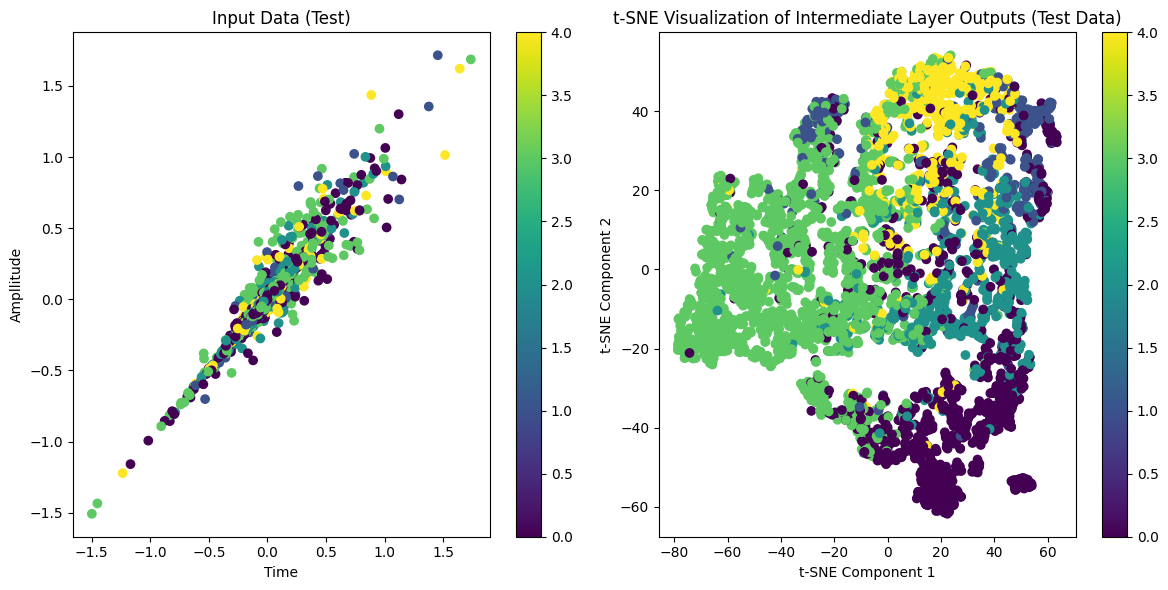

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model

# Load the saved model
saved_model_path = r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5'
model = load_model(saved_model_path)

# Define a function to extract intermediate layer outputs
def extract_intermediate_outputs(model, data):
    intermediate_model = Model(inputs=model.input, outputs=model.layers[-3].output)  # Output right before the output layer
    intermediate_output = intermediate_model.predict(data)
    return intermediate_output

# Extract intermediate layer outputs for the test data
intermediate_output_test = extract_intermediate_outputs(model, x_test)

# Apply t-SNE to intermediate layer outputs for the test data
tsne = TSNE(n_components=2, random_state=42)
tsne_output_test = tsne.fit_transform(intermediate_output_test)

# Plot the results for the test data
plt.figure(figsize=(12, 6))

# Plot input data
plt.subplot(1, 2, 1)
# Flatten the input data to have the same size as y_test
x_test_flattened = x_test.reshape(x_test.shape[0], -1)
plt.scatter(x_test_flattened[:, 0], x_test_flattened[:, 1], c=y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('Input Data (Test)')
plt.xlabel('Time')
plt.ylabel('Ampllitude')

# Plot intermediate layer outputs right before the output layer
plt.subplot(1, 2, 2)
plt.scatter(tsne_output_test[:, 0], tsne_output_test[:, 1], c=y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Intermediate Layer Outputs (Test Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()


FILTER RECORDS

In [11]:
import numpy as np

# Assuming y_test and x_test are already defined
# y_test.shape = (4381, 5)
# x_test.shape = (4381, 12, 1000, 1)

# Find the indices where the sum of each row of y_test is equal to 1
single_class_indices = np.where(np.sum(y_test, axis=1) == 1)[0]

# Filter y_test and x_test based on single_class_indices
filtered_y_test = y_test[single_class_indices]
filtered_x_test = x_test[single_class_indices]

# Now filtered_y_test will contain only rows where there is a single class-label,
# and filtered_x_test will contain their corresponding data.

print("Shape of filtered_y_test:", filtered_y_test.shape)
print("Shape of filtered_x_test:", filtered_x_test.shape)


Shape of filtered_y_test: (3287, 5)
Shape of filtered_x_test: (3287, 12, 1000, 1)


2024-02-27 11:16:13.179581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1682 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-02-27 11:16:14.725912: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 11:16:15.417258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-27 11:16:15.616913: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


103/103 [==============================] - 7s 43ms/step


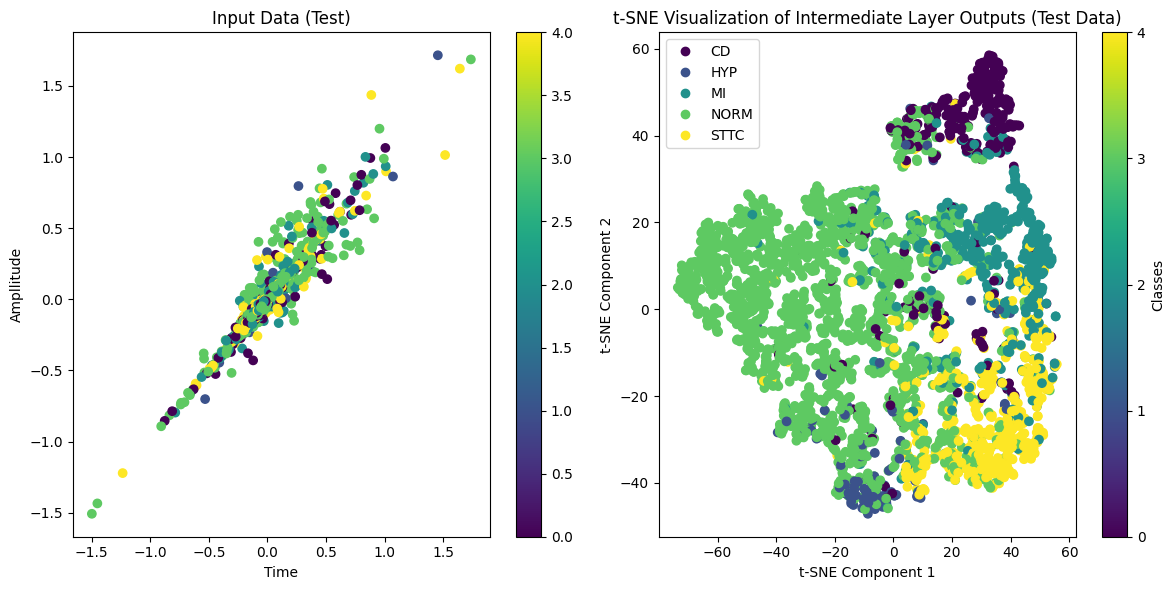

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model

# Load the saved model
saved_model_path = r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5'
model = load_model(saved_model_path)

# Define the classes list
classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

# Assuming filtered_x_test and filtered_y_test are defined as in the previous code block

# Define a function to extract intermediate layer outputs
def extract_intermediate_outputs(model, data):
    intermediate_model = Model(inputs=model.input, outputs=model.layers[-3].output)  # Output right before the output layer
    intermediate_output = intermediate_model.predict(data)
    return intermediate_output

# Extract intermediate layer outputs for the test data
intermediate_output_test = extract_intermediate_outputs(model, filtered_x_test)

# Apply t-SNE to intermediate layer outputs for the test data
tsne = TSNE(n_components=2, random_state=42)
tsne_output_test = tsne.fit_transform(intermediate_output_test)

# Plot the results for the test data
plt.figure(figsize=(12, 6))

# Plot input data
plt.subplot(1, 2, 1)
# Flatten the input data to have the same size as filtered_y_test
filtered_x_test_flattened = filtered_x_test.reshape(filtered_x_test.shape[0], -1)
plt.scatter(filtered_x_test_flattened[:, 0], filtered_x_test_flattened[:, 1], c=filtered_y_test.argmax(axis=1), cmap='viridis')
plt.colorbar()
plt.title('Input Data (Test)')
plt.xlabel('Time')
plt.ylabel('Ampllitude')

# Plot intermediate layer outputs right before the output layer
plt.subplot(1, 2, 2)
scatter = plt.scatter(tsne_output_test[:, 0], tsne_output_test[:, 1], c=filtered_y_test.argmax(axis=1), cmap='viridis')
plt.colorbar(scatter, ticks=range(len(classes)), label='Classes')
plt.title('t-SNE Visualization of Intermediate Layer Outputs (Test Data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add legend
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.tight_layout()
plt.show()


In [16]:
from tensorflow.keras.models import load_model
model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5')

In [17]:

# y_pred_train = model.predict(x_train)
y_pred  = model.predict(x_test)

137/137 [==============================] - 7s 44ms/step


In [18]:
y_pred

array([[1.0493596e-02, 5.3092656e-03, 8.1835784e-02, 8.9591396e-01,
        1.2190790e-02],
       [1.0608609e-02, 2.0849421e-03, 9.4297165e-03, 9.7705722e-01,
        4.7580986e-03],
       [3.5958963e-03, 3.2418850e-04, 5.0769415e-04, 9.9499196e-01,
        1.4321957e-03],
       ...,
       [1.1298234e-01, 1.2809457e-02, 6.2581599e-01, 1.8080990e-01,
        1.9854929e-01],
       [4.7423407e-03, 3.4846022e-04, 9.3799632e-04, 9.9303389e-01,
        1.8033209e-03],
       [1.7090533e-02, 2.0187190e-03, 2.2066347e-03, 9.7978598e-01,
        4.8296484e-03]], dtype=float32)

In [19]:


from sklearn.metrics import classification_report, precision_recall_curve, f1_score, roc_auc_score, accuracy_score, auc
import numpy as np
from sklearn.metrics import confusion_matrix

def sklearn_metrics(y_true, y_pred, mlb):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5] = 0
    
    # Convert binary predictions back to class labels using MultiLabelBinarizer
    predicted_classes = mlb.inverse_transform(y_bin)

    # Use a set to accumulate all distinct classes
    distinct_classes = set()

    # Iterate over predicted classes and add them to the set
    for classes in predicted_classes:
        distinct_classes.update(classes)

    # Convert the set of distinct classes to a sorted list
    class_names = sorted(list(distinct_classes))

    # Print classification report for each class
    print("\nClassification Report:")
    print(classification_report(y_true, y_bin, target_names=class_names))

    # Calculate specificity for each class
    print("\nSpecificity for each class:")
    for i, class_name in enumerate(class_names):
        tn, fp, _, _ = confusion_matrix(y_true[:, i], y_bin[:, i]).ravel()
        specificity = tn / (tn + fp)
        print(f"{class_name}: {specificity:.2f}")

# Assuming mlb is the MultiLabelBinarizer used for transforming the labels
sklearn_metrics(y_test, y_pred, mlb)



Classification Report:
              precision    recall  f1-score   support

          CD       0.82      0.67      0.74       992
         HYP       0.74      0.47      0.57       530
          MI       0.85      0.69      0.76      1092
        NORM       0.82      0.91      0.86      1919
        STTC       0.77      0.73      0.75      1049

   micro avg       0.81      0.75      0.78      5582
   macro avg       0.80      0.69      0.74      5582
weighted avg       0.81      0.75      0.77      5582
 samples avg       0.78      0.76      0.76      5582


Specificity for each class:
CD: 0.96
HYP: 0.98
MI: 0.96
NORM: 0.85
STTC: 0.93


/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


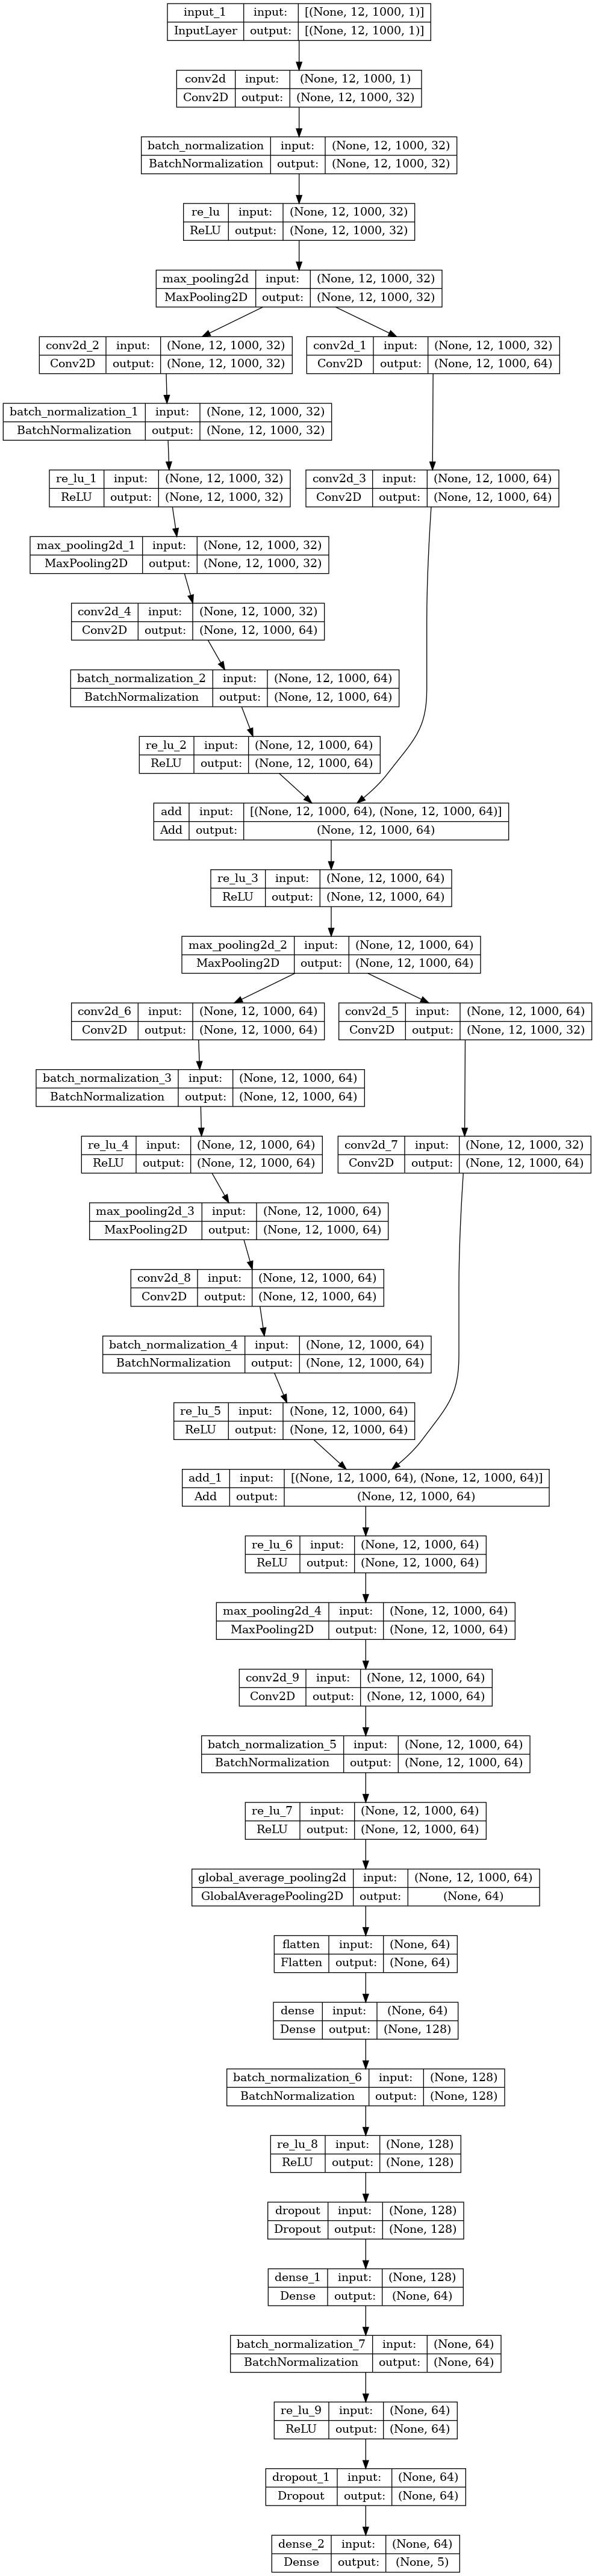

In [2]:
from keras.utils import plot_model
from keras.applications.resnet50 import ResNet50

plot_model(model, to_file='ST-CNN-5_final1new.png', show_shapes=True)

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5')
y_pred_train = model.predict(x_train)
y_pred_test  = model.predict(x_test)

from sklearn.metrics import classification_report, precision_recall_curve, f1_score, roc_auc_score, accuracy_score, auc
import numpy as np

def sklearn_metrics(y_true, y_pred, mlb):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5]  = 0

#     print("y_train shape:", y_true.shape)
# p   print("y_test shape :", y_pred.shape)


    # Compute area under precision-Recall curve
    auc_sum = 0
    for i in range(y_true.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        auc_sum += auc(recall, precision)

    print("Accuracy        : {:.2f}".format(accuracy_score(y_true.flatten(), y_bin.flatten()) * 100))
    print("Macro AUC score : {:.2f}".format(roc_auc_score(y_true, y_pred, average='macro') * 100))
    print('AUROC           : {:.2f}'.format((auc_sum / y_true.shape[1]) * 100))
    print("Micro F1 score  : {:.2f}".format(f1_score(y_true, y_bin, average='micro') * 100))

    # Convert binary predictions back to class labels using MultiLabelBinarizer
    predicted_classes = mlb.inverse_transform(y_bin)
    # print("predicted_classes:", predicted_classes)


    # Use a set to accumulate all distinct classes
    distinct_classes = set()

    # Iterate over predicted classes and add them to the set
    for classes in predicted_classes:
        distinct_classes.update(classes)

    # Convert the set of distinct classes to a sorted list
    class_names = sorted(list(distinct_classes))
    # print("class_names:", class_names)

    # Print classification report for each class
    print("\nClassification Report:")
    print(classification_report(y_true, y_bin, target_names=class_names))

# Assuming mlb is the MultiLabelBinarizer used for transforming the labels
sklearn_metrics(y_test, y_pred_test, mlb)

Accuracy        : 89.12
Macro AUC score : 93.24
AUROC           : 82.31
Micro F1 score  : 77.79
predicted_classes: [('NORM',), ('NORM',), ('NORM',), (), (), (), (), ('STTC',), ('STTC',), ('CD',), (), ('NORM',), ('STTC',), ('NORM',), ('CD',), ('NORM',), ('STTC',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('CD', 'NORM'), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM', 'STTC'), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('STTC',), ('NORM',), ('NORM',), ('STTC',), (), ('NORM',), ('MI', 'STTC'), ('NORM',), ('NORM',), ('CD',), ('STTC',), ('CD', 'HYP', 'STTC'), ('NORM',), (), ('HYP', 'STTC'), ('STTC',), ('CD', 'MI'), ('HYP',), ('NORM',), ('NORM',), ('CD',), ('MI',), ('STTC',), ('MI',), (), ('NORM',), ('CD',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('NORM',), ('MI',), ('NORM',), ('STTC',), ('NORM',), ('NORM',), ('HYP', 'STTC'), ('NORM',), ('NORM',), ('MI',), ('

/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


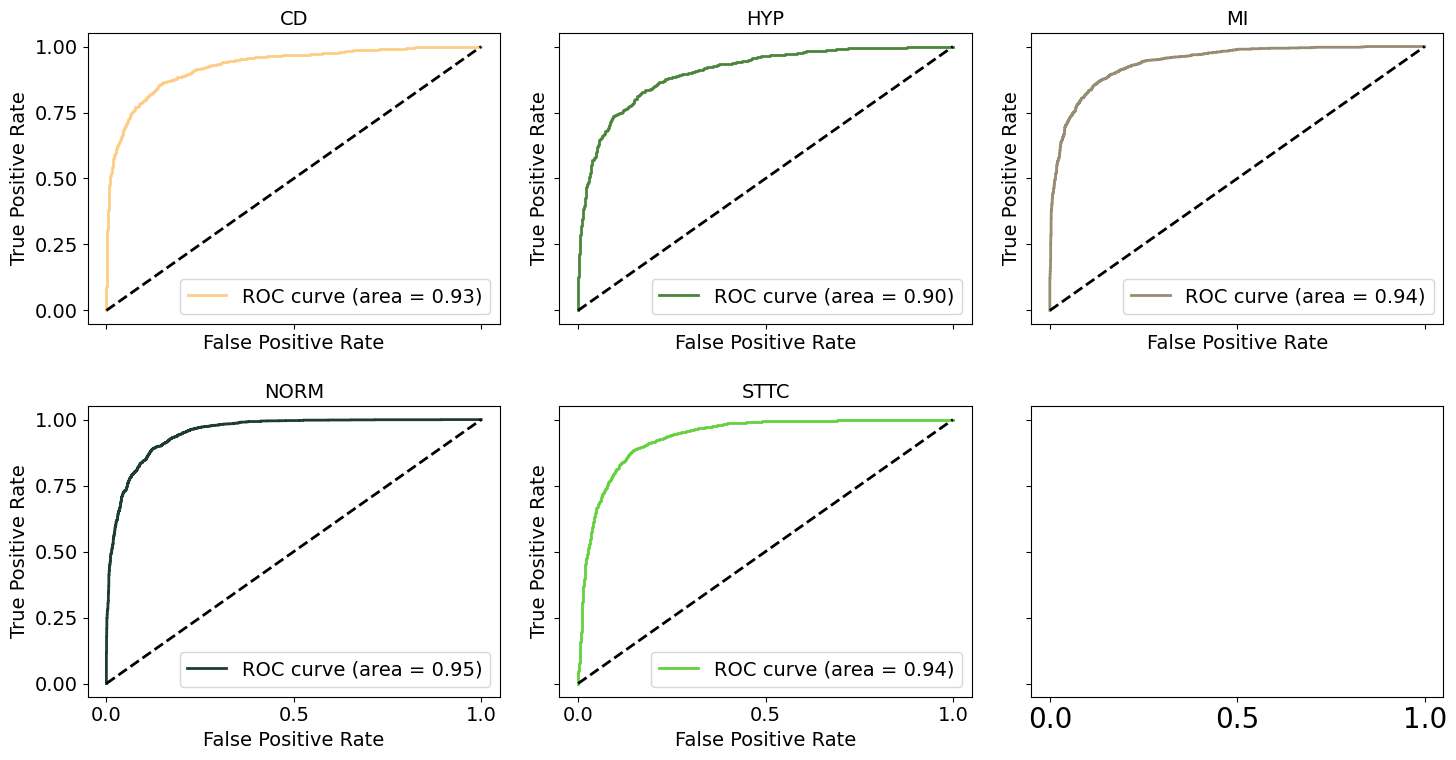

In [27]:
from numpy.core.fromnumeric import size
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import random
import matplotlib.pyplot as plt

def plot_ROC_Curve(y_true, y_pred, rows, height, fontsize=12):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5]  = 0

    # Convert binary predictions back to class labels using MultiLabelBinarizer
    predicted_classes = mlb.inverse_transform(y_bin)

    # Use a set to accumulate all distinct classes
    distinct_classes = set()

    # Iterate over predicted classes and add them to the set
    for classes in predicted_classes:
        distinct_classes.update(classes)

    # Convert the set of distinct classes to a sorted list
    class_names = sorted(list(distinct_classes))


    #########
    label_binarizer = label_binarize(y_true, classes=class_names)
    n_classes = label_binarizer.shape[1]
    lw = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15,height), sharex=True, sharey=True)
    for i, n, ax in zip(range(n_classes), class_names ,axes.flatten()):
        color = (random.random(), random.random(), random.random())
        ax.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve (area = {1:0.2f})".format(i, roc_auc[i]),
        )
        ax.set_xlabel('False Positive Rate', fontsize=fontsize)
        ax.set_ylabel('True Positive Rate', fontsize=fontsize)
        ax.plot([0, 1], [0, 1], "k--", lw=lw)
        ax.legend(loc="lower right", fontsize=fontsize)
        ax.title.set_text(n)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    plt.tight_layout()  
    plt.show()


plot_ROC_Curve(y_test, y_pred_test, 2, 8, fontsize=14)

In [19]:
from sklearn.metrics import confusion_matrix

def sklearn_metrics(y_true, y_pred, mlb):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5]  = 0

    # Compute area under precision-recall curve
    auc_sum = 0
    for i in range(y_true.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        auc_sum += auc(recall, precision)

    # Calculate specificity for each class
    specificities = []
    for i in range(y_true.shape[1]):
        tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_bin[:, i]).ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        specificities.append(specificity)

    print("Accuracy        : {:.2f}".format(accuracy_score(y_true.flatten(), y_bin.flatten()) * 100))
    print("Macro AUC score : {:.2f}".format(roc_auc_score(y_true, y_pred, average='macro') * 100))
    print('AUROC           : {:.2f}'.format((auc_sum / y_true.shape[1]) * 100))
    print("Micro F1 score  : {:.2f}".format(f1_score(y_true, y_bin, average='micro') * 100))

    # Print specificity for each class
    print("\nSpecificity for Each Class:")
    for i, specificity in enumerate(specificities):
        print(f"Class {mlb.classes_[i]}: {specificity:.2f}")

    # Convert binary predictions back to class labels using MultiLabelBinarizer
    predicted_classes = mlb.inverse_transform(y_bin)

    # Use a set to accumulate all distinct classes
    distinct_classes = set()

    # Iterate over predicted classes and add them to the set
    for classes in predicted_classes:
        distinct_classes.update(classes)

    # Convert the set of distinct classes to a sorted list
    class_names = sorted(list(distinct_classes))

    # Print classification report for each class
    print("\nClassification Report:")
    print(classification_report(y_true, y_bin, target_names=class_names))


In [20]:
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, roc_auc_score, accuracy_score, auc
import numpy as np

# Assuming mlb is the MultiLabelBinarizer used for transforming the labels
sklearn_metrics(y_test, y_pred_test, mlb)


Accuracy        : 88.56
Macro AUC score : 92.44
AUROC           : 80.96
Micro F1 score  : 76.39

Specificity for Each Class:
Class CD: 0.96
Class HYP: 0.97
Class MI: 0.96
Class NORM: 0.81
Class STTC: 0.95

Classification Report:
              precision    recall  f1-score   support

          CD       0.83      0.67      0.74       992
         HYP       0.70      0.46      0.56       530
          MI       0.84      0.65      0.73      1092
        NORM       0.80      0.93      0.86      1919
        STTC       0.81      0.62      0.70      1049

   micro avg       0.81      0.73      0.76      5582
   macro avg       0.80      0.67      0.72      5582
weighted avg       0.81      0.73      0.76      5582
 samples avg       0.77      0.74      0.74      5582



/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5')
y_pred_train = model.predict(x_train)
y_pred_test  = model.predict(x_test)



137/137 [==============================] - 5s 39ms/step


In [22]:
from sklearn.metrics import  roc_auc_score
print("*** roc_auc_score ***")
print("\n#------- exp1.1.1 : superdiagnostic -------#")
print(roc_auc_score(y_test, y_pred_test))

*** roc_auc_score ***

#------- exp1.1.1 : superdiagnostic -------#
0.9323744752967846


In [18]:
threshold = 0.5

def apply_threshold (threshold, indicator):
  for iy, ix in np.ndindex(indicator.shape):
   if indicator[iy, ix] > threshold:
      indicator[iy, ix] = 1
   else:
      indicator[iy, ix] = 0
  return indicator  

indicator_exp1_1_1 = np.copy(y_pred_test)
indicator_exp1_1_1 = apply_threshold(threshold, indicator_exp1_1_1)

In [19]:
from sklearn.metrics import multilabel_confusion_matrix


superdiagnostic_CM = multilabel_confusion_matrix(y_test, indicator_exp1_1_1)

def find_mean_metrics(TP, TN, FP, FN, exp_name):
  accuracy = (TP + TN) / (FP + TP + TN + FN)
  precision = TP / (TP + FP) 
  recall = TP / (TP + FN) 
  f1_score = (2 * precision * recall) / (precision + recall)
  specificity = TN / (TN + FP) 
  print("\n--- " + exp_name + " ---")
  #Find the mean ignoring the NaN value (nanmean)
  print("Accuracy: " + f'{np.nanmean(accuracy):.4f}')
  print("Precision: " + f'{np.nanmean(precision):.4f}') #Positive Predictive Value (PPV)
  print("Recall: " + f'{np.nanmean(recall):.4f}') #True Positive Rate
#   print("F1_Score: " + f'{np.nanmean(f1_score):.4f}') #Harmonic Mean of the Precision and Recall
  print("Specificity: " + f'{np.nanmean(specificity):.4f}' + "\n") #True Negative Rate


#Super-Diagnostic
TN_superdiagnostic = superdiagnostic_CM[:, 0, 0]
TP_superdiagnostic = superdiagnostic_CM[:, 1, 1]
FN_superdiagnostic = superdiagnostic_CM[:, 1, 0]
FP_superdiagnostic = superdiagnostic_CM[:, 0, 1]
find_mean_metrics(TP_superdiagnostic, TN_superdiagnostic, FP_superdiagnostic, FN_superdiagnostic, "Super-Diagnostic")


--- Super-Diagnostic ---
Accuracy: 0.8856
Precision: 0.7968
Recall: 0.6657
Specificity: 0.9325



Old report

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, accuracy_score, auc, classification_report

def sklearn_metrics(y_true, y_pred):
    y_bin = np.copy(y_pred)
    y_bin[y_bin >= 0.5] = 1
    y_bin[y_bin < 0.5]  = 0

    # Compute area under precision-Recall curve
    auc_sum = 0
    for i in range(5):
      precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:,i])
      auc_sum += auc(recall, precision)

    print("Accuracy        : {:.2f}".format(accuracy_score(y_true.flatten(), y_bin.flatten())* 100))
    print("Macro AUC score : {:.2f}".format(roc_auc_score(y_true, y_pred, average='macro') * 100))
    print('AUROC           : {:.2f}'.format((auc_sum / 5) * 100))
    print("Micro F1 score  : {:.2f}".format(f1_score(y_true, y_bin, average='micro') * 100))
    
    # Print classification report for each class
    # class_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    class_names = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
    print("\nClassification Report:")
    print(classification_report(y_true, y_bin, target_names=class_names))



In [ ]:
from tensorflow.keras.models import load_model
model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_final1.h5')
y_pred_train = model.predict(x_train)
y_pred_test  = model.predict(x_test)

16/16 [==============================] - 1s 38ms/step


In [ ]:

print("Train")
sklearn_metrics(y_train, y_pred_train)
print("\nTest")
sklearn_metrics(y_test, y_pred_test)


Train
Accuracy        : 80.76
Macro AUC score : 86.34
AUROC           : 72.15
Micro F1 score  : 51.68

Classification Report:
              precision    recall  f1-score   support

          CD       0.67      0.71      0.69       428
         HYP       0.82      0.18      0.30       205
          MI       0.51      0.76      0.61       353
        NORM       0.98      0.30      0.46      1102
        STTC       0.95      0.20      0.33       434

   micro avg       0.70      0.41      0.52      2522
   macro avg       0.78      0.43      0.48      2522
weighted avg       0.84      0.41      0.48      2522
 samples avg       0.45      0.39      0.41      2522


Test
Accuracy        : 79.92
Macro AUC score : 84.73
AUROC           : 69.48
Micro F1 score  : 49.70

Classification Report:
              precision    recall  f1-score   support

          CD       0.61      0.71      0.66        91
         HYP       1.00      0.21      0.35        56
          MI       0.53      0.79      0.6

/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/jayao/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/D1/homes/j